# Snow Cover Extent and Near-Surface Air Temperature bias LS3MIP IPSL
conda env: `phd_v3` (in `envs/phd`)

Try to compare the **snow cover** a,d **temperature** for the **CMIP6 historical** experiments: **coupled** + **land-hist**
- Zone: **HMA**
- Period: **1979-2014**
- Model: **IPSL-CMA6-LR**
- Observations: 
    - `snc`: **NOAA Climate Data Record (CDR)** of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1: https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756 (satellite)
    - `tas`: **CRU TS4.04** Climatic Research Unit (CRU) Time-Series (TS) version 4.04 of high-resolution gridded data of month-by-month variation in climate (Jan. 1901- Dec. 2019): http://data.ceda.ac.uk/badc/cru/data/cru_ts/cru_ts_4.04/data/tmp (station)

Created: 17/09/2020 - Last modified: 17/09/2020

## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [6]:
period = slice('1979','2014')
seasons = ['Annual', 'DJF', 'JJA']

# Get HMA domain + make a extended version for regridding properly on the edges
latlim, lonlim = u.get_domain_HMA()
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

var_snc = 'snc'
table_snc = u.get_table(var_snc)
label_snc, units_snc, cmap_snc, levels_snc = u.get_var_infos(var_snc)

var_tas = 'tas'
table_tas = u.get_table(var_tas)
label_tas, units_tas, cmap_tas, levels_tas = u.get_var_infos(var_tas)

## Load models

In [4]:
# list_models = u.get_model_names()
list_models = ['IPSL-CM6A-LR']

for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var_snc)
    print(institute, grid, realization, calendar)

IPSL-CM6A-LR (1/1)
IPSL gr r1i1p1f1 gregorian


In [5]:
def check_snc(da):
    # Some models have values between 0 and 1 even if units in %    
    if da.max().values <= 1.1:
        with xr.set_options(keep_attrs=True):
            da = da*100
        da.attrs['units'] = '%'

    # Some models have wrong values (+-0.1 for numeric precision)
    da = da.where( (da >= -0.1) & (da <= 100.1) )

In [7]:
# Load historical
da_historical_snc = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table_snc+'/'+var_snc+'/'+grid+'/latest/*.nc', 
    combine='by_coords'
).sel(time=period, lat=latlim_ext, lon=lonlim_ext)[var_snc].chunk({'time': -1, 'lon': -1, 'lat': -1})

# Load land-hist
da_land_hist_snc = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table_snc+'/'+var_snc+'/'+grid+'/latest/*.nc', 
    combine='by_coords'
).sel(time=period, lat=latlim_ext, lon=lonlim_ext)[var_snc].chunk({'time': -1, 'lon': -1, 'lat': -1})

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, da_historical_snc.time.size)
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, da_land_hist_snc.time.size)

# snc (0-1 to % when needed and take out wrong values)
check_snc(da_historical_snc)
check_snc(da_land_hist_snc)

In [12]:
# Load historical
da_historical_tas = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table_tas+'/'+var_tas+'/'+grid+'/latest/*.nc', 
    combine='by_coords'
).sel(time=period, lat=latlim_ext, lon=lonlim_ext)[var_tas].chunk({'time': -1, 'lon': -1, 'lat': -1}) - 273.15

# Load land-hist
da_land_hist_tas = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table_tas+'/'+var_tas+'/'+grid+'/latest/*.nc', 
    combine='by_coords'
).sel(time=period, lat=latlim_ext, lon=lonlim_ext)[var_tas].chunk({'time': -1, 'lon': -1, 'lat': -1}) - 273.15

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, da_historical_tas.time.size)
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, da_land_hist_tas.time.size)

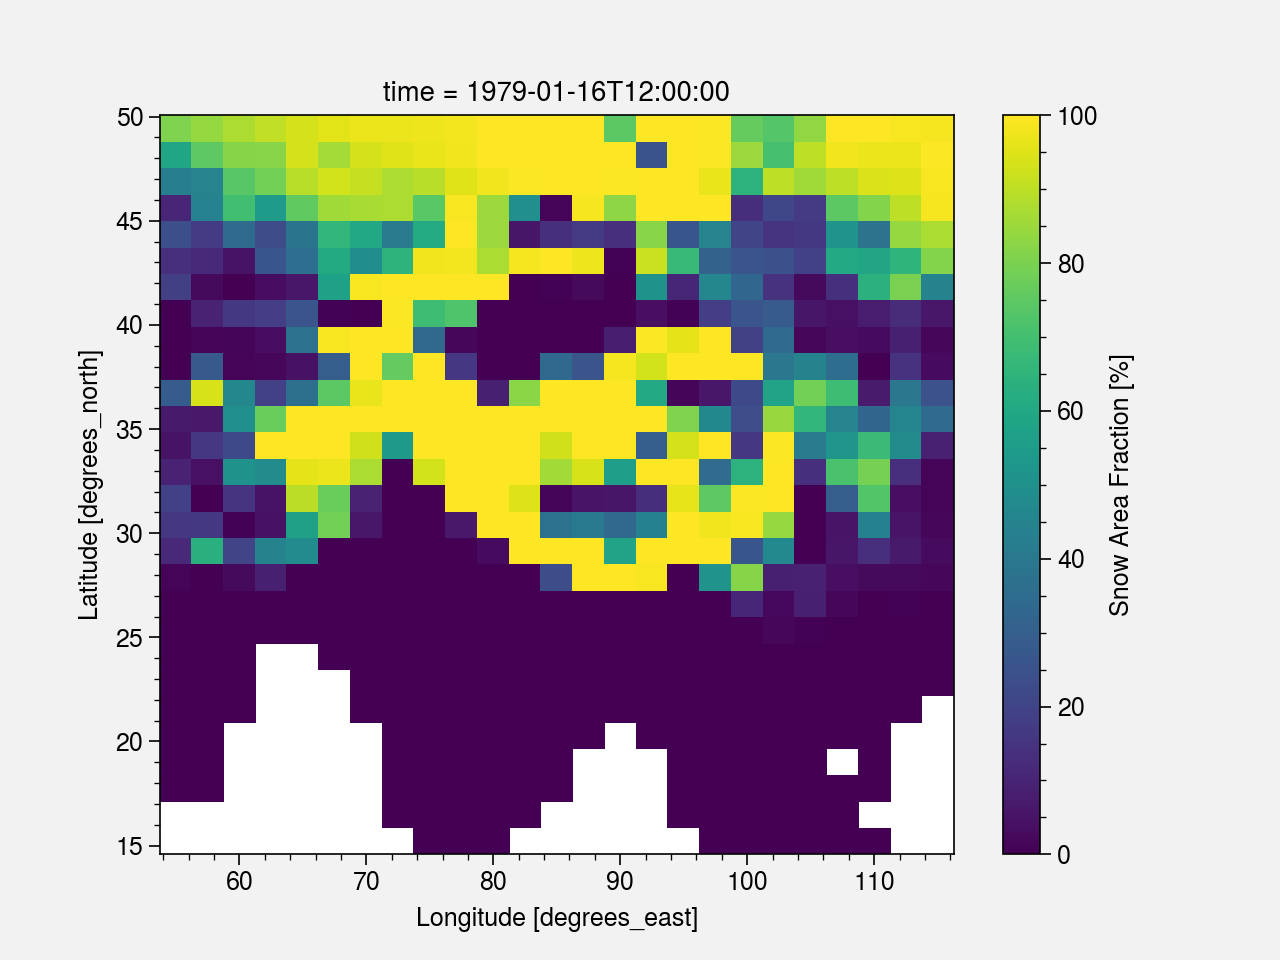

In [9]:
da_historical_snc.isel(time=0).plot()

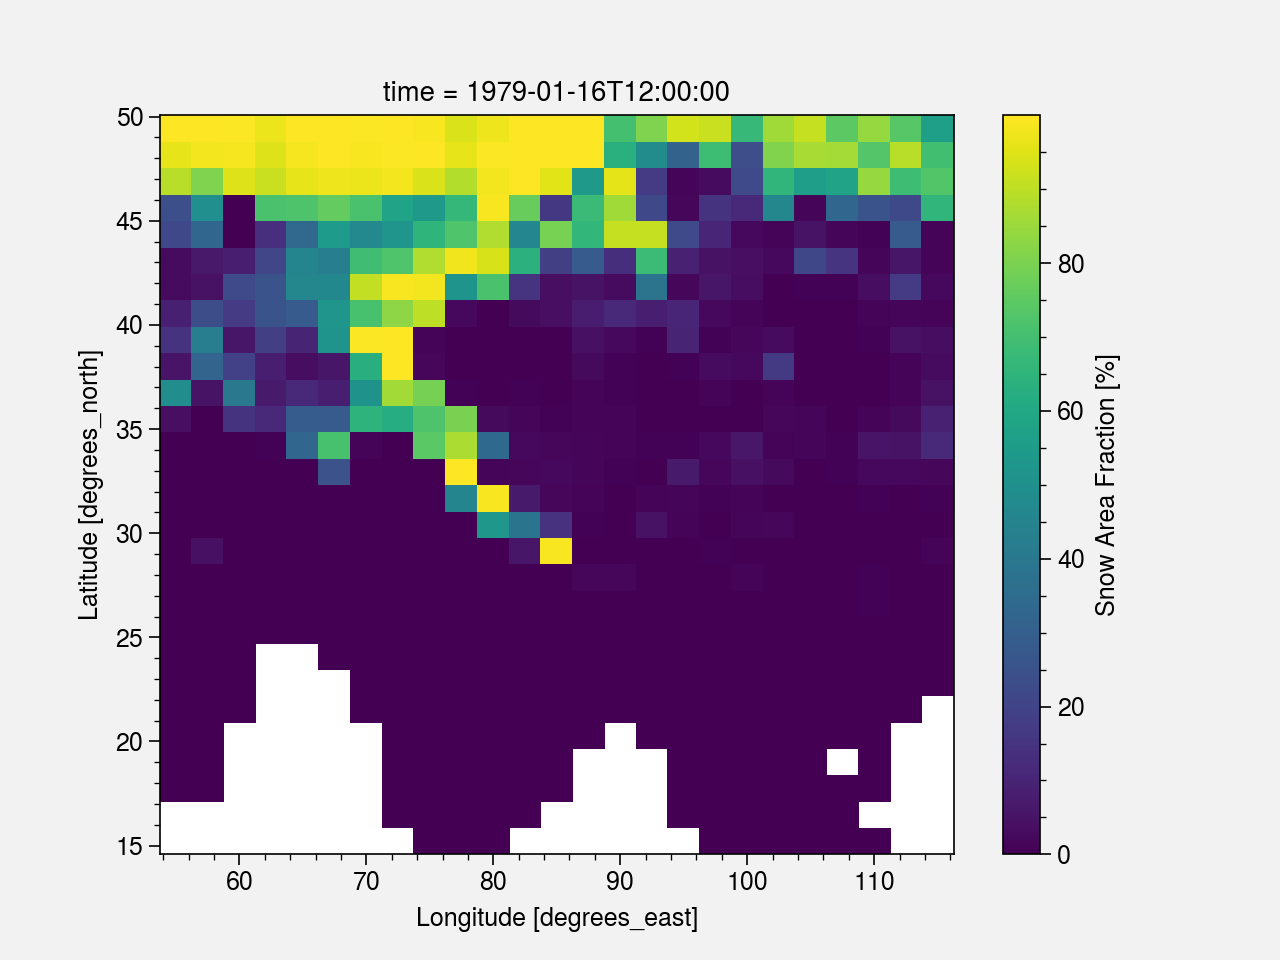

In [14]:
da_land_hist_snc.isel(time=0).plot()

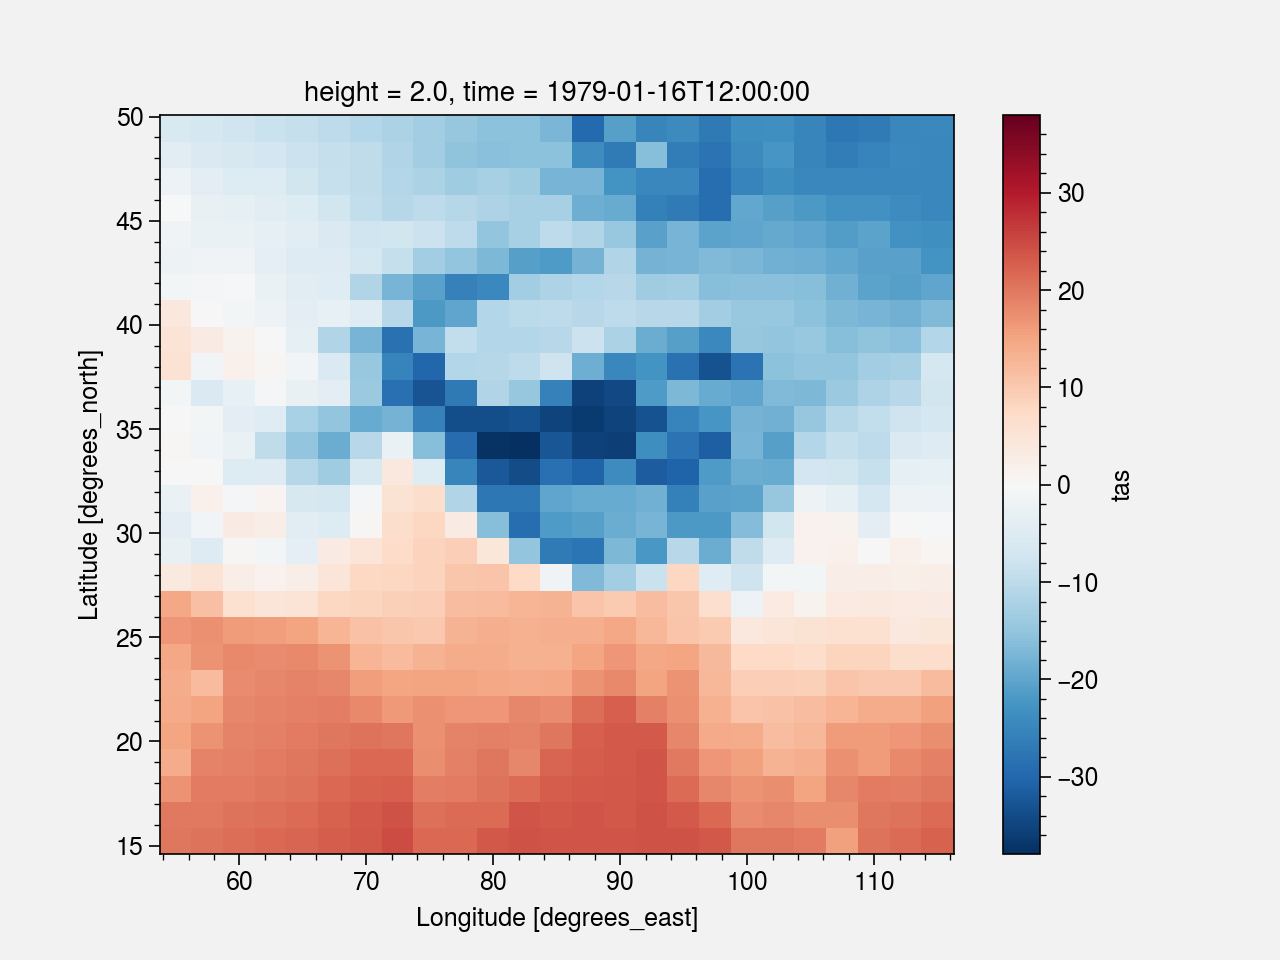

In [15]:
da_historical_tas.isel(time=0).plot()

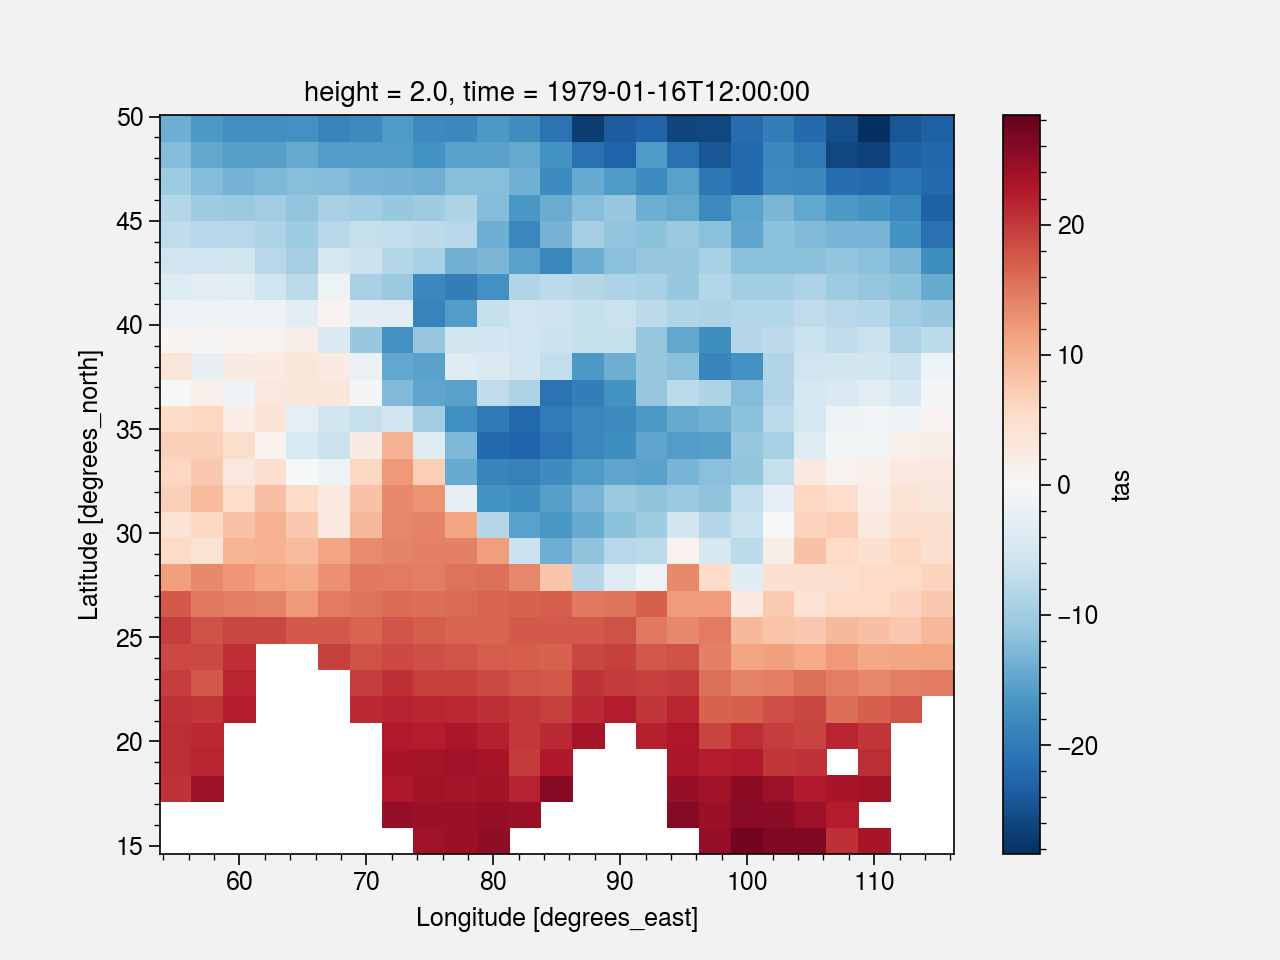

In [16]:
da_land_hist_tas.isel(time=0).plot()

## Load observation snc
NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1:
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756 (satellite)

*The data record for the **NH** SCE CDR spans from October 4, **1966 to present**. Prior to June 1999 the NH SCE CDR is based on satellite-derived maps of NH SCE produced **weekly** by trained NOAA meteorologists. Early NH SCE maps were based on a visual interpretation of photographic copies of shortwave imagery. Analysts incorporated various sources of imagery into the SCE mapping process as they became available (e.g. AVHRR, VAS). In June 1999 NOAA NH SCE maps were replaced by SCE output from the Interactive Multisensor Snow and Ice Mapping System (IMS) at the National Ice Center (NIC). SCE output from the NIC IMS is processed at Rutgers University and appended to the NH SCE CDR to form a cohesive, long-term climate record of SCE.*

Other observations: https://globalcryospherewatch.org/reference/snow_inventory.php

In [28]:
raw_obs_ds_snc = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
# raw_obs_ds

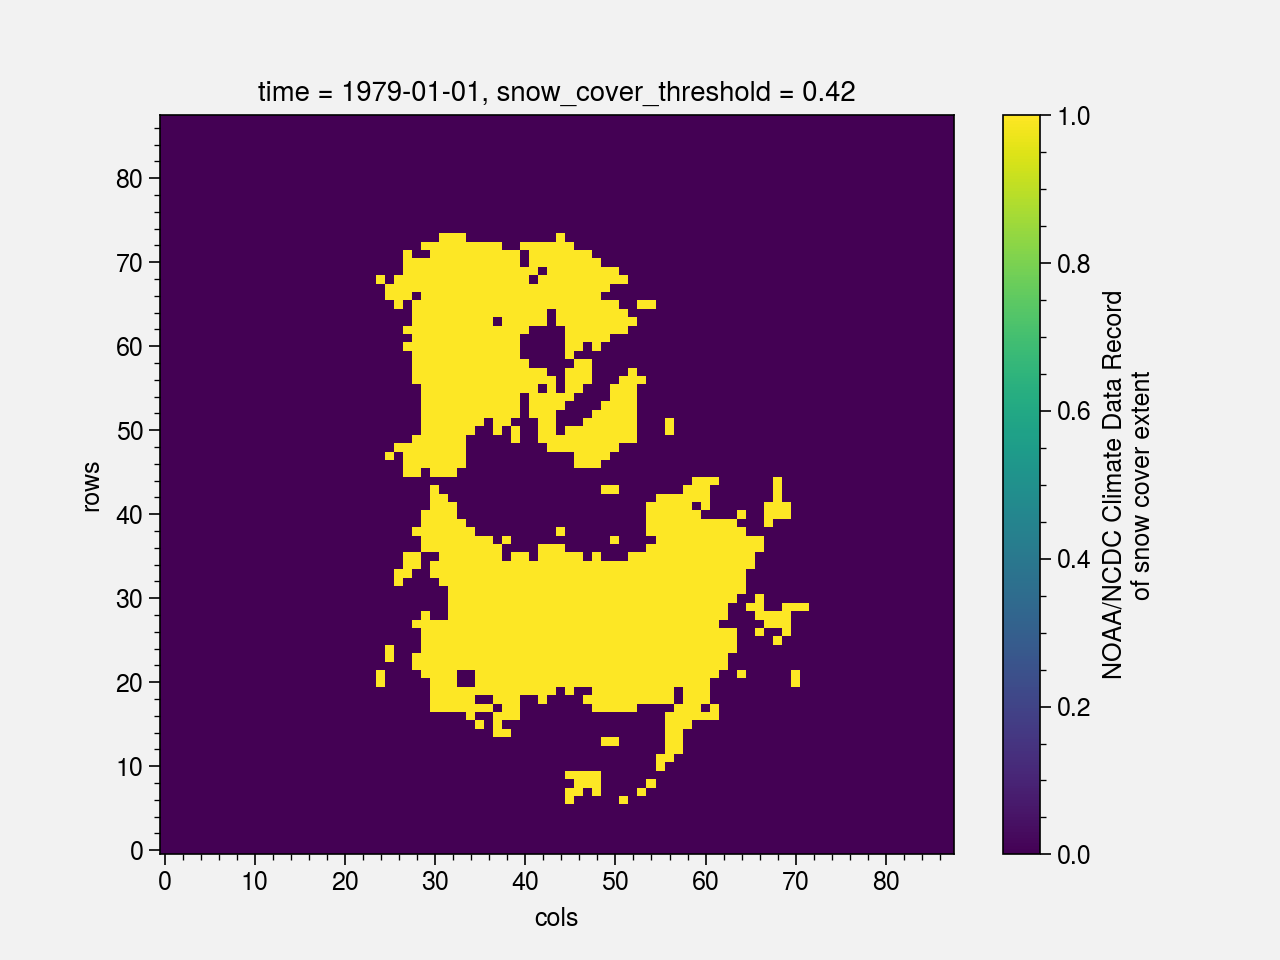

In [29]:
raw_obs_ds_snc.isel(time=0).snow_cover_extent.plot()

### Convert weekly to monthly SCE (units %)

In [30]:
# Get the snc variable, keep only land data and convert to %
obs_snc = raw_obs_ds_snc.snow_cover_extent.where(raw_obs_ds_snc.land == 1)*100  
obs_snc.attrs['units'] = '%'
obs_snc.attrs['long_name'] = raw_obs_ds_snc.snow_cover_extent.long_name
obs_snc.attrs['short_name'] = 'NOAA/NCDC CDR'
obs_snc = obs_snc.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs_snc = obs_snc.resample(time='M').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs_snc.time.size)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


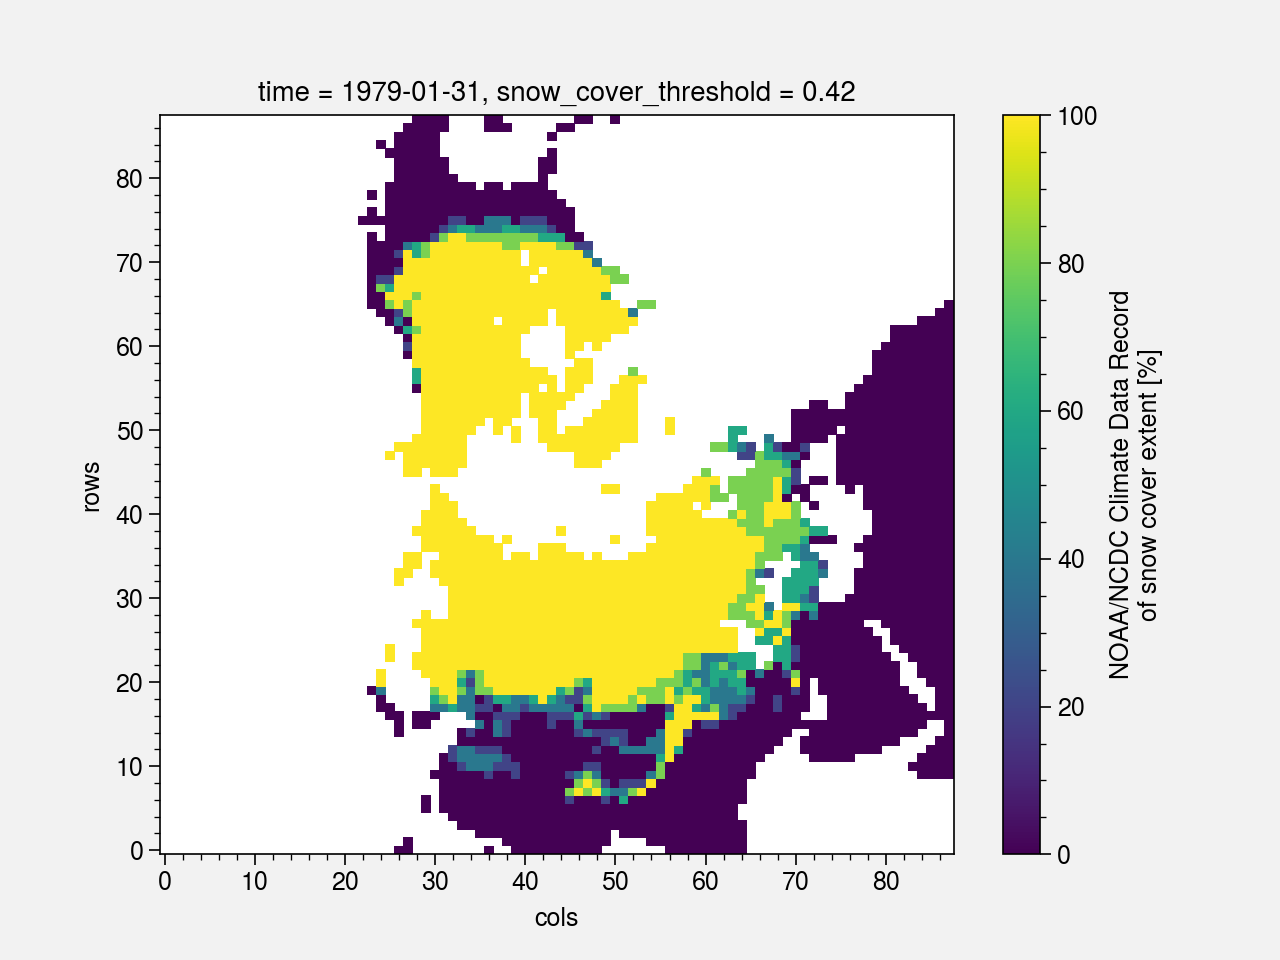

In [31]:
obs_snc.isel(time=0).plot()

## Regrid observation to the model grid
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [43]:
# To put NaNs instead of 0 where there is no data (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder


regridder = xe.Regridder(obs_snc, da_historical_snc, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_snc_regrid = (regridder(obs_snc)).sel(lat=latlim, lon=lonlim)

Reuse existing file: bilinear_88x88_28x25.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


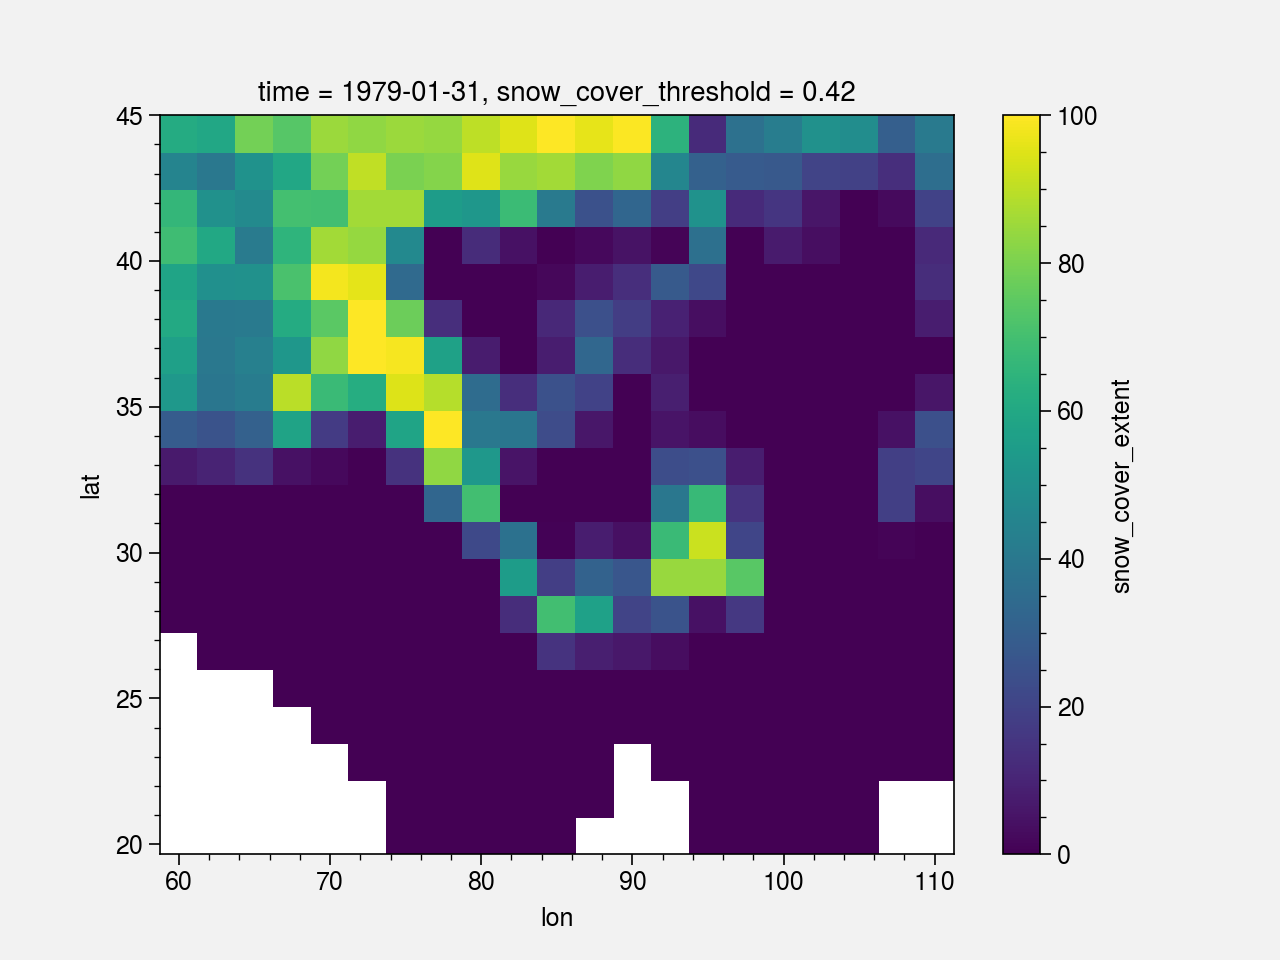

In [44]:
obs_snc_regrid.isel(time=0).plot()

## Load observation tas
**CRU TS4.04** Climatic Research Unit (CRU) Time-Series (TS) version 4.04 of high-resolution gridded data of month-by-month variation in climate (Jan. 1901- Dec. 2019): http://data.ceda.ac.uk/badc/cru/data/cru_ts/cru_ts_4.04/data/tmp (station)

*The gridded Climatic Research Unit (CRU) Time-series (TS) data version 4.04 data are **month-by-month** variations in climate over the **period 1901-2019**, provided on **high-resolution (0.5x0.5 degree)** grids, produced by CRU at the University of East Anglia and funded by the UK National Centre for Atmospheric Science (NCAS), a NERC collaborative centre.*

*The CRU TS4.04 data were produced using **angular-distance weighting (ADW) interpolation**. All versions prior to 4.00 used triangulation routines in IDL. Please see the release notes for full details of this version update.*

*The CRU TS4.04 data are monthly gridded fields based on monthly observational data calculated from daily or sub-daily data by National Meteorological Services and other external agents. The ASCII and NetCDF data files both contain monthly mean values for the various parameters. The NetCDF versions contain an additional integer variable, ’stn’, which provides, for each datum in the main variable, a count (between 0 and 8) of the number of stations used in that interpolation. The missing value code for 'stn' is -999.*

*All CRU TS output files are actual values - NOT anomalies.*

In [34]:
obs_tas_ds = xr.open_dataset('/data/mlalande/CRU/tmp/cru_ts4.04.1901.2019.tmp.dat.nc').sel(time=period, lat=latlim_ext, lon=lonlim_ext)

In [35]:
# obs_tas_ds

In [36]:
obs_tas = obs_tas_ds.tmp
obs_tas.attrs['units'] = '°C'
obs_tas.attrs['long_name'] = 'Climatic Research Unit (CRU) Time-Series (TS) version 4.04'
obs_tas.attrs['short_name'] = 'CRU TS4.04'

In [37]:
# obs_tas

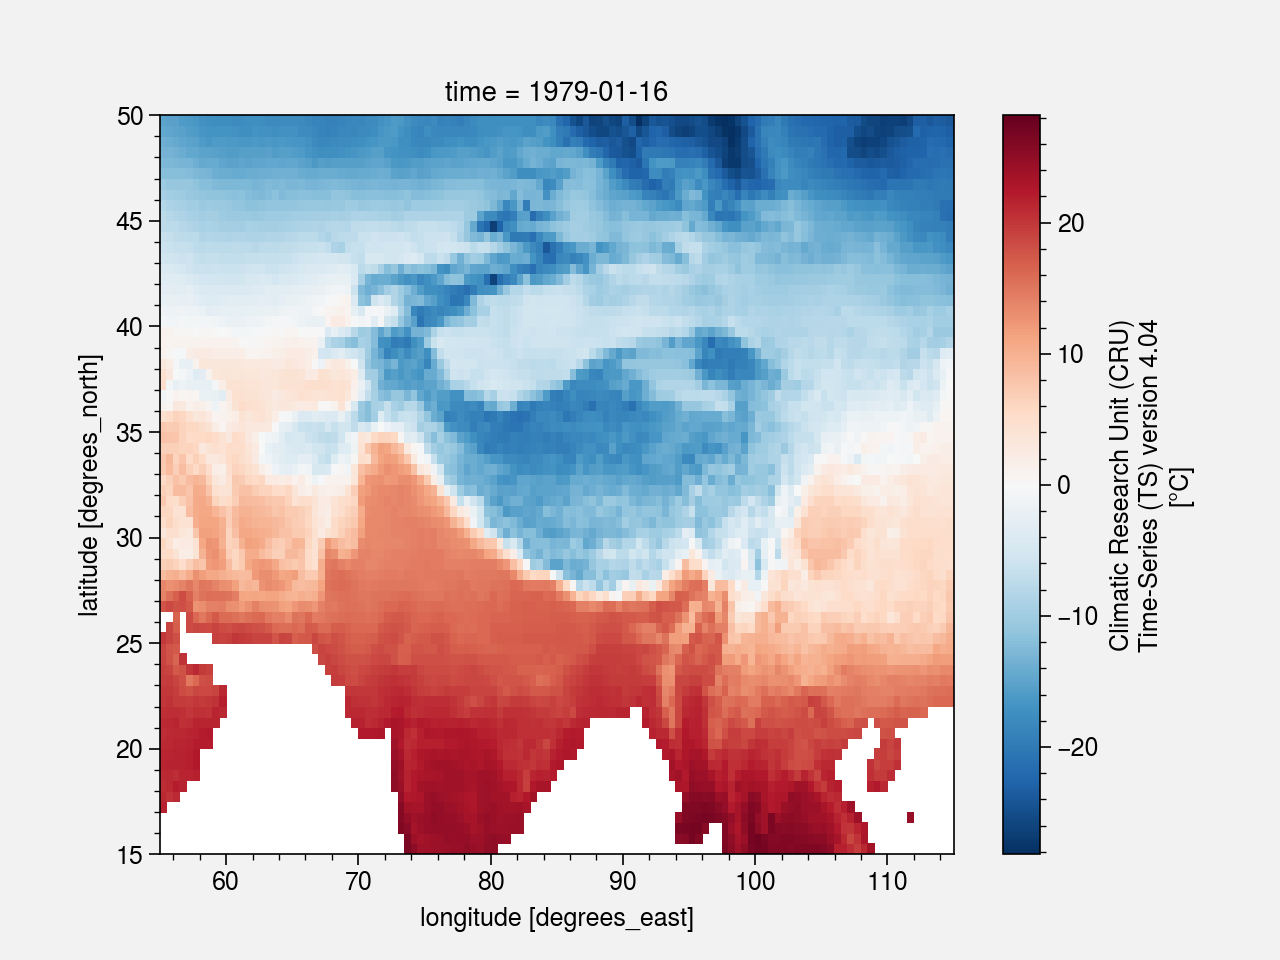

In [38]:
obs_tas.isel(time=0).plot()

## Regrid observation to the model grid
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [41]:
# # To put NaNs instead of 0 where there is no data (https://github.com/JiaweiZhuang/xESMF/issues/15)
# import scipy
# def add_matrix_NaNs(regridder):
#         X = regridder.weights
#         M = scipy.sparse.csr_matrix(X)
#         num_nonzeros = np.diff(M.indptr)
#         M[num_nonzeros == 0, 0] = np.NaN
#         regridder.weights = scipy.sparse.coo_matrix(M)
#         return regridder


regridder = xe.Regridder(obs_tas, da_historical_tas, 'bilinear', periodic=False, reuse_weights=True)
# regridder = add_matrix_NaNs(regridder)
obs_tas_regrid = (regridder(obs_tas)).sel(lat=latlim, lon=lonlim)

Reuse existing file: bilinear_70x120_28x25.nc


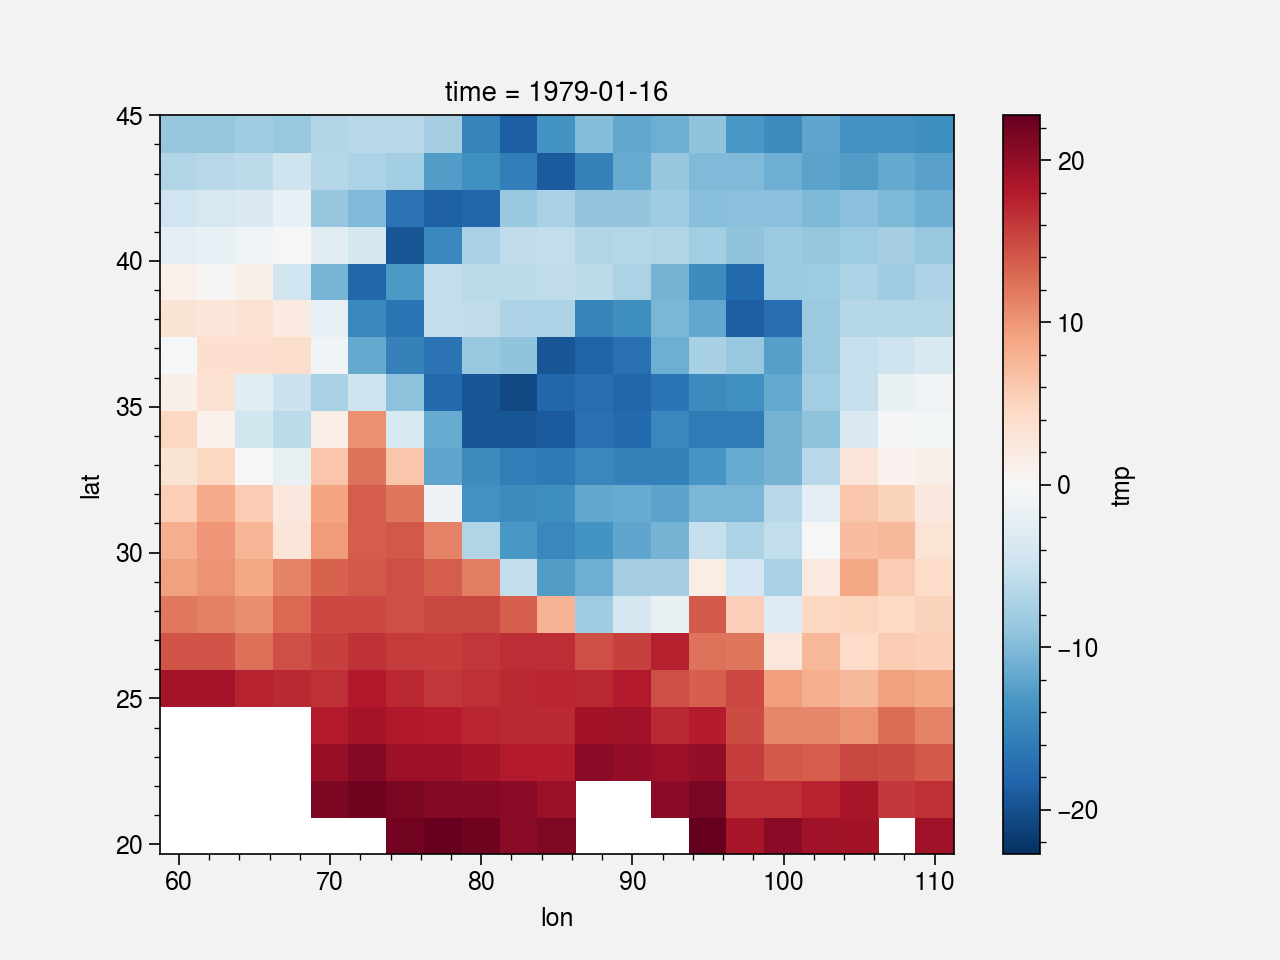

In [42]:
obs_tas_regrid.isel(time=0).plot()

## Compare plots

### Climatology

In [46]:
clim_snc_historical = [None]*len(seasons)
clim_snc_land_hist = [None]*len(seasons)
clim_obs_snc_regrid = [None]*len(seasons)

for i, season in enumerate(seasons):
    clim_snc_historical[i] = u.clim(da_historical_snc, season=season, calendar=calendar)
    clim_snc_land_hist[i] = u.clim(da_land_hist_snc, season=season, calendar=calendar)
    clim_obs_snc_regrid[i] = u.clim(obs_snc_regrid, season=season, calendar=calendar)

In [54]:
clim_tas_historical = [None]*len(seasons)
clim_tas_land_hist = [None]*len(seasons)
clim_obs_tas_regrid = [None]*len(seasons)

for i, season in enumerate(seasons):
    clim_tas_historical[i] = u.clim(da_historical_tas, season=season, calendar=calendar)
    clim_tas_land_hist[i] = u.clim(da_land_hist_tas, season=season, calendar=calendar)
    clim_obs_tas_regrid[i] = u.clim(obs_tas_regrid, season=season, calendar=calendar)

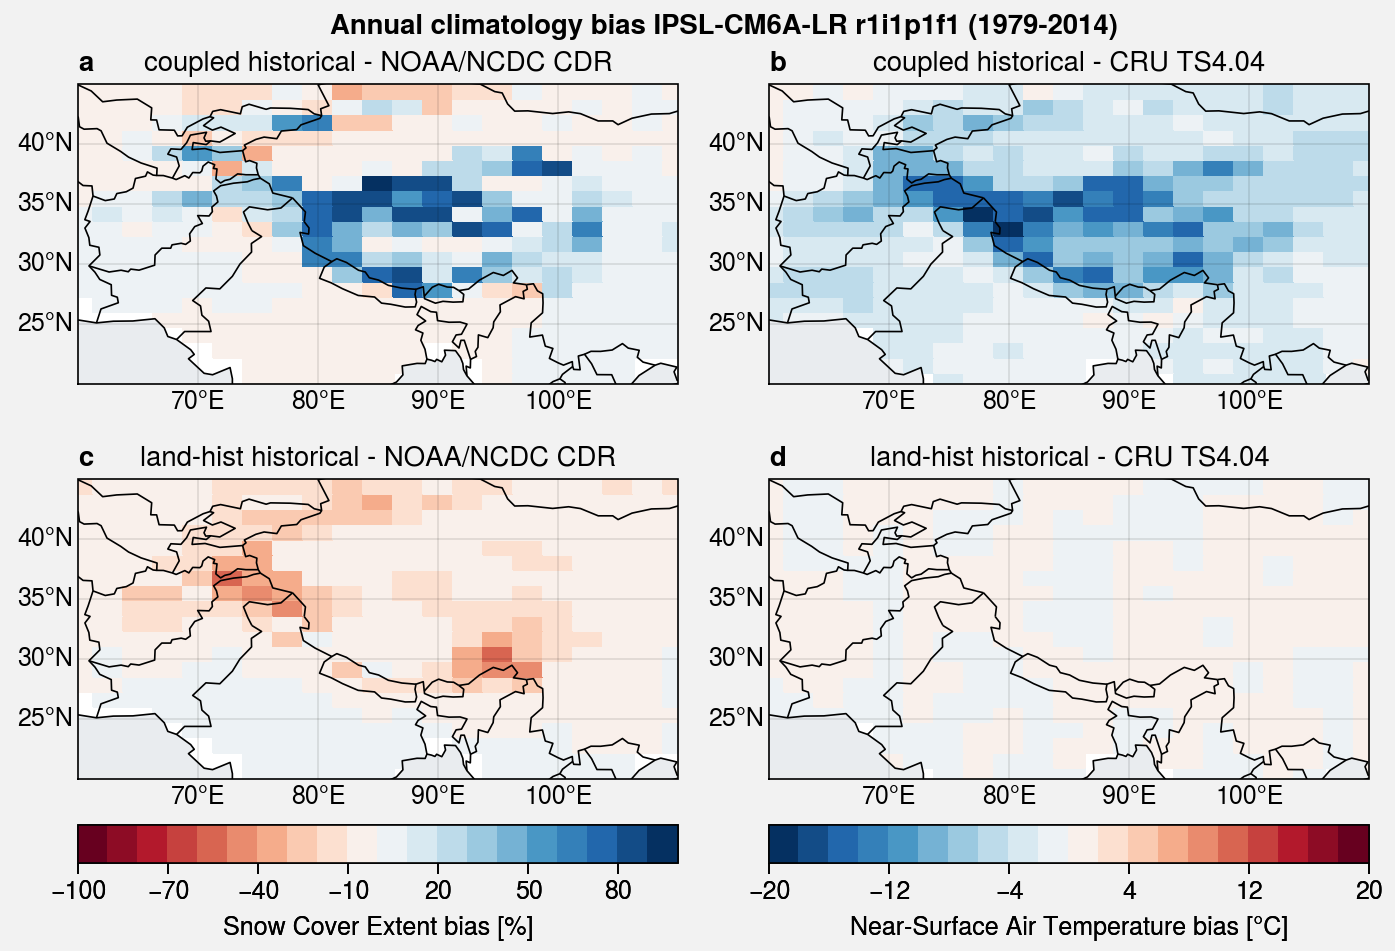

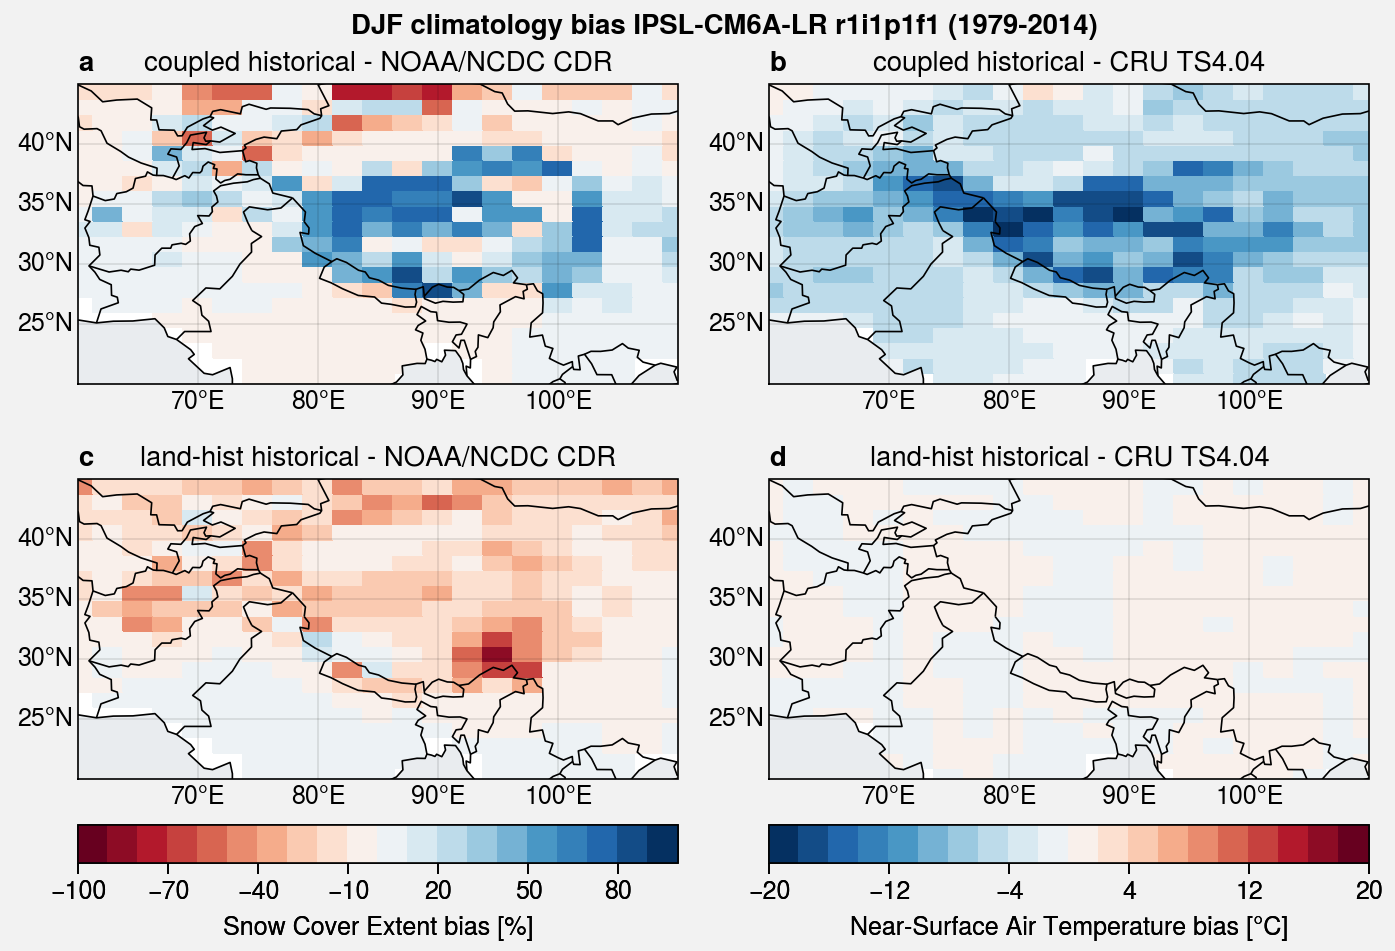

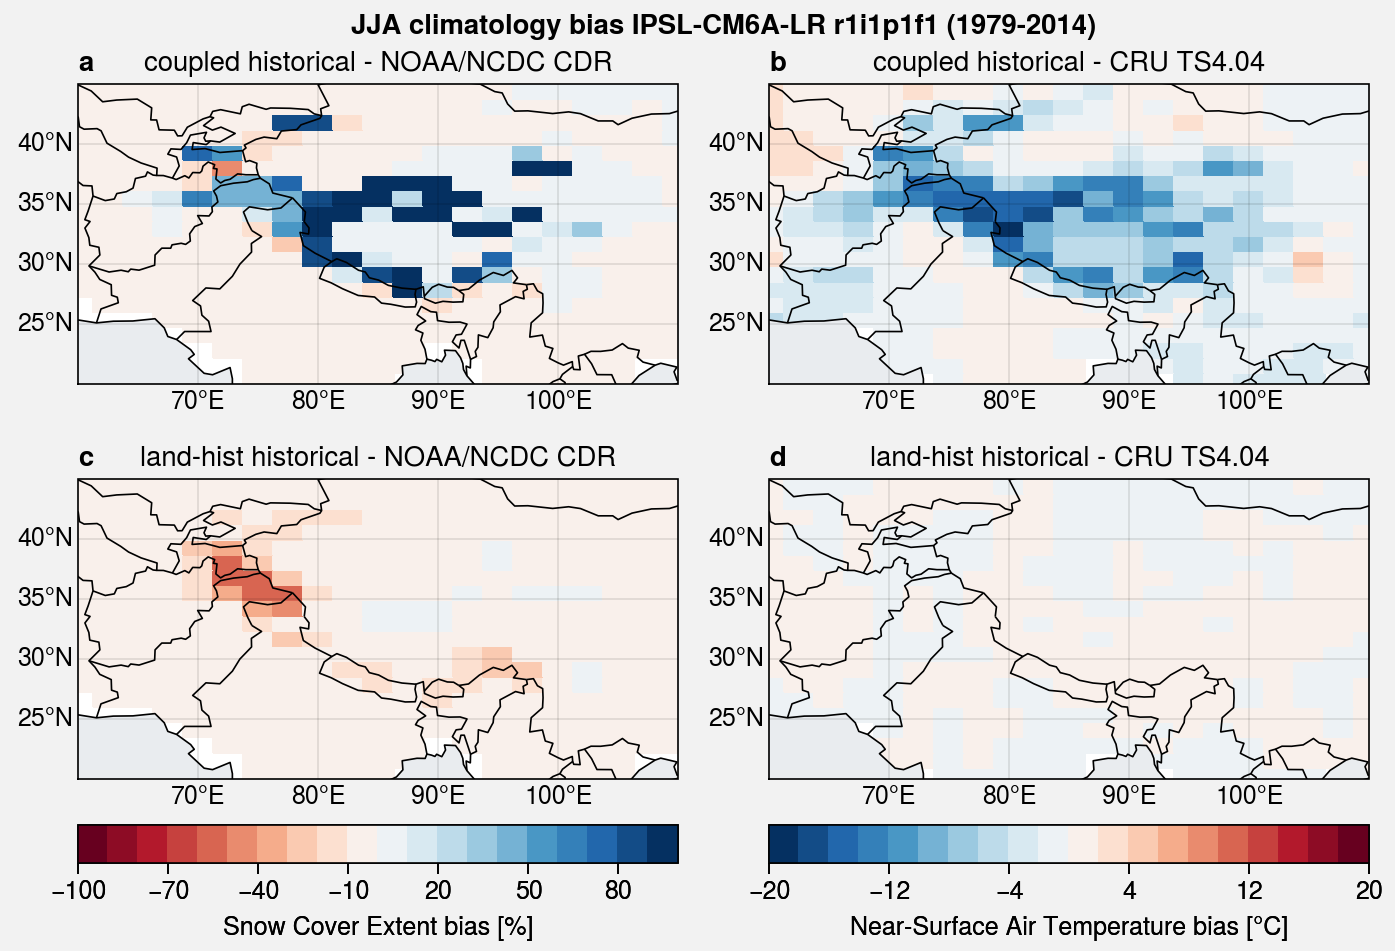

In [73]:
cmap_snc='RdBu'
levels_snc=plot.arange(-100,100,10)
extend_snc='neither'

cmap_tas='RdBu_r'
levels_tas=plot.arange(-20,20,2)
extend_tas='neither'

for i, season in enumerate(seasons): 
# for i, season in enumerate(['Annual']): 
    fig, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, axwidth=3)
    
    axs.format(
        labels=True,
        latlim=(latlim.start,latlim.stop), lonlim=(lonlim.start,lonlim.stop),
        ocean=True, oceancolor='gray2',
        coast=True, borders=True,
        suptitle=season+' climatology bias '+model+' '+realization+' ('+period.start+'-'+period.stop+')',
        abc=True
    )

    # Snow cover
    axs[0].pcolormesh(clim_snc_historical[i] - clim_obs_snc_regrid[i], cmap=cmap_snc, levels=levels_snc, extend=extend_snc)
    axs[0].format(title='coupled historical - '+obs_snc.short_name)
    
    m_snc = axs[2].pcolormesh(clim_snc_land_hist[i] - clim_obs_snc_regrid[i], cmap=cmap_snc, levels=levels_snc, extend=extend_snc)
    axs[2].format(title='land-hist historical - '+obs_snc.short_name)
    
    axs[2].colorbar(m_snc, label=label_snc+' bias ['+units_snc+']', loc='b')
    
    # Near-Surface Air Temperature
    axs[1].pcolormesh(clim_tas_historical[i] - clim_obs_tas_regrid[i], cmap=cmap_tas, levels=levels_tas, extend=extend_tas)
    axs[1].format(title='coupled historical - '+obs_tas.short_name)
    
    m_tas = axs[3].pcolormesh(clim_tas_land_hist[i] - clim_obs_tas_regrid[i], cmap=cmap_tas, levels=levels_tas, extend=extend_tas)
    axs[3].format(title='land-hist historical - '+obs_tas.short_name)
    
    axs[3].colorbar(m_tas, label=label_tas+' bias ['+units_tas+']', loc='b')   
    

    filename = season+'_snc_tas_bias_'+model+'_'+realization+'_LS3MIP_'+period.start+'-'+period.stop
#     fig.save('img/IPSL/'+filename+'.jpg'), fig.save('img/IPSL/'+filename+'.png'), fig.save('img/IPSL/'+filename+'.pdf')